# AIMs Positions, Populations and MAFs

In [1]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

## Compare the panels

In [81]:
from components.panel_analyser import PanelAnalyser
from components.panel import Panel


panels = [p for p in Panel.all_panels()
          if "GAL" in p.label and "from" not in p.label and "Falt" not in p.label]

analyser = PanelAnalyser()
count_comparison = analyser.compare_panel_lengths(panels + Panel.all_control_panels())
ancestry_comparison = analyser.compare_AIMs_ancestry(panels)
lsbl_comparison = analyser.compare_LSBL(panels)

print("== Counts\n")
print(count_comparison.to_latex())
print()

print("== Counts per ancestry\n")
print(ancestry_comparison[["GAL_Completo", "GAL_Affy"]].to_latex())
print()

print("== LSBL cumsum per ancestry\n")
print(lsbl_comparison[[("GAL_Completo", "LSBL(Fst)"), ("GAL_Affy", "LSBL(Fst)")]].to_latex())


== Counts

\begin{tabular}{llr}
\toprule
{} & AIMs count &  Ratio \\
Panel        &            &        \\
\midrule
GAL\_Completo &        445 &   1.00 \\
GAL\_Affy     &        179 &   0.40 \\
CPx100       &     43,144 &  96.95 \\
CPx10        &      4,424 &   9.94 \\
CPx1         &        438 &   0.98 \\
\bottomrule
\end{tabular}


== Counts per ancestry

\begin{tabular}{lrlrl}
\toprule
{} & GAL\_Completo &                  &   GAL\_Affy &                  \\
{} &   AIMs count & Panel Percentage & AIMs count & Panel Percentage \\
\midrule
AFR &          115 &              26\% &         62 &              35\% \\
EUR &          202 &              45\% &         71 &              40\% \\
NAM &          129 &              29\% &         47 &              26\% \\
\bottomrule
\end{tabular}


== LSBL cumsum per ancestry

\begin{tabular}{lrr}
\toprule
{} & GAL\_Completo &  GAL\_Affy \\
{} &    LSBL(Fst) & LSBL(Fst) \\
population &              &           \\
\midrule
AFR        &         73

En GAL_Affy observamos un aumento de la proporción de AIMs africanos respecto de los europeos, mientras que la proporción de AIMs americanos sigue igual. Esto podría tener por consecuencia, a primera vista, una sobreestimación del componente africano al usar GAL_Affy. No obstante, debe calcularse el LSBL acumulado de los SNPs de cada grupo y comparar *ese* valor.

Los AIMs que quedan en GAL_Affy siguen balanceados en cuanto a LSBL para determinar los componentes EUR y NAM. EL valor de LSBL queda relativamente más alto que en GAL_Completo, por lo que debemos estar atentos a posibles diferencias en resultado entre GAL_Affy y GAL_Completo que afecten específicamente al componente ancestral africano --en particular, que lo sobreestimen.

Sin embargo, esto no parece ser un problema en nuestros resultados, al menos para las muestras de 1000 Genomas utilizadas. La comparación de proporción de ancestría africana estimada para las diferentes poblaciones parece mantenerse igual entre ambos paneles, a pesar de esa reducción diferencial de AIMs. Con todo, este _caveat_ quedará para futuros usos de GAL_Affy.

/home/juan/repos/tesina/components/genome.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for i in centromers.index]


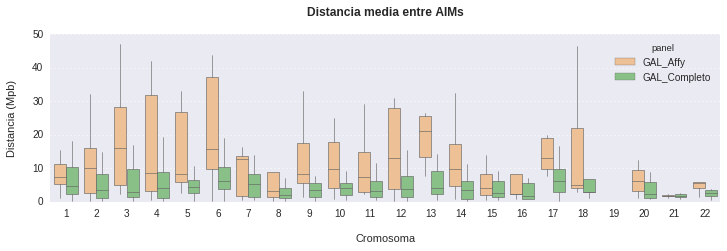

In [82]:
from plotters.snp_distances import SnpDistances


SnpDistances().snp_distances_comparison_boxplot(["GAL_Completo", "GAL_Affy"])

## Comparar Galanter de PLoS / dbSNP / ...

In [83]:
# galanter_remapped = pd.read_csv("/home/juan/tesina/files/galanter.GRCh38.p6.bed", sep="\t",
#                                names=['chr', 'position', 'pos_to', 'id'], comment="#", skiprows=3,
#                                usecols=['chr', 'position', 'pos_to', 'id'])

# # The online remapping generated weird chromosomes
# weird_chromosomes = galanter_remapped["chr"].str.contains("_")
# galanter_remapped.drop(galanter_remapped[weird_chromosomes].index, inplace=True)

# galanter_remapped['chr'] = galanter_remapped['chr'].str.replace("chr", "").astype(int)
# galanter_remapped.drop_duplicates("id", keep="last", inplace=True)
# galanter_remapped.set_index('id', inplace=True)

# galanter_plos = galanter[['chr', 'position']]

# import re

# galanter_dbSNP = pd.read_csv("/home/juan/tesina/files/galanter_rsIDs_dbSNP",
#                              names=['id', 'source', 'chr', 'pos', 'pos_to'], skiprows=1).set_index('id')
# take_these_out = galanter_dbSNP.chr.str.contains('HSCHR')
# galanter_dbSNP = galanter_dbSNP[~take_these_out]
# galanter_dbSNP['chr'] = galanter_dbSNP['chr'].astype(int)
# galanter_dbSNP = galanter_dbSNP.drop_duplicates()

# galanter.index.difference(galanter_remapped.index)

# print(galanter.index.difference(galanter_remapped.index))
# print(galanter_remapped.index.difference(galanter.index))

Debería usar las posiciones de el build `GRCh38.p6` en `galanter_remapped`, pero no están todas puede ser? Chequear

## Generate CONTROL PANELS of random SNPs

- Extract the **same amount * factor** of SNPs per chromosome as Galanter has,
  with some min space between them.
- The SNPs to extract should all be present in LAT-1


The script to generate the SNPs lists is `./scripts/generate_control_panels.py`

With the generated SNP lists per chromosome, we need to extract those variants
from the 1000 Genomes `*.vcf` files, using PLINK.

The script for this is `/home/juan/tesina/1000 ... /create_control_panels.sh`

In [84]:
# # I think this is not needed anymore:
# galanter.groupby("chr").size().to_csv("data/chr_SNP_count_in_galanter")

## Plot the distribution of AIMs per chromosome

* Chromosome lengths were taken from:

[Assembly Statistics for GRCh38.p6 Release date: December 23, 2015](http://www.ncbi.nlm.nih.gov/projects/genome/assembly/grc/human/data/)

* Centromere ranges were taken from the FTP server: 

ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA_000001405.21_GRCh38.p6/GCA_000001405.21_GRCh38.p6_assembly_structure/genomic_regions_definitions.txt

El archivo `galanter.bed` con las posiciones de los AIMs reportadas por Galanter *et al.* correspondía al genoma de referencia `GRCh37.p5`. La conversión al build `GRCh38.p6` fue realizada online con la herramienta de *remapping* provista por NCBI Genome Tools, de modo que fueran coherentes con la información sobre longitud total de los cromosomas y rango de los centrómeros.

http://www.ncbi.nlm.nih.gov/genome/tools/remap

In [85]:
# galanter["pos"] = galanter_remapped["position"]

/home/juan/repos/tesina/components/genome.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for i in centromers.index]
/home/juan/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


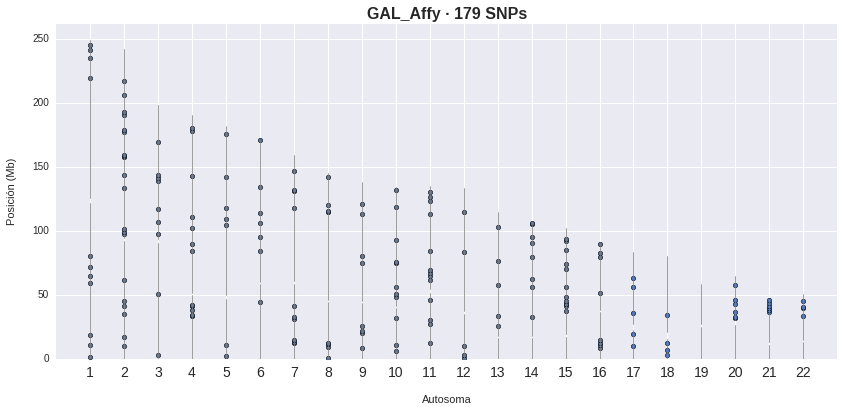

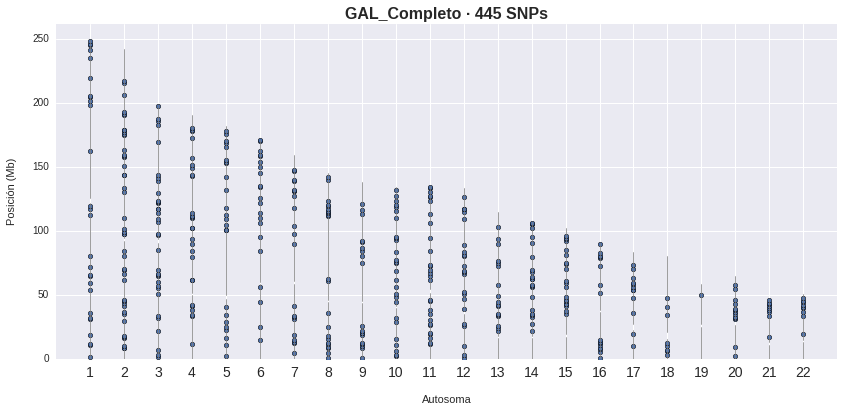

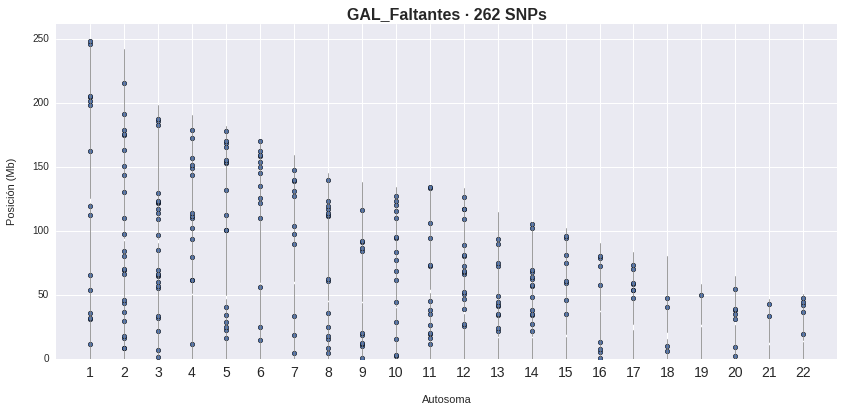

In [86]:
import matplotlib.pyplot as plt

from components.panel import Panel
from plotters.snp_distances import SnpDistances


plotter = SnpDistances()
for panel in Panel.all_panels():
    plotter.chromosomes_with_SNPs_plot(panel)

## Descarga de data de 1000Genomes

In [87]:
# %load /home/juan/tesina/1000genomes/ftp_download_1000_genomes.py

In [88]:
# % run extract_SNPs_from_vcf_chromosomes.py

# commands = extract_SNPs_from_vcf(galanter.index.values)

# ^ One time only run, to extract the SNPs out of the big files of 1000genomes:
# run_commands(commands, "/home/juan/tesina/1000genomes")

## Compute MAF by Population (1000 Genomes data)

I use both `plink` and `pandas` for this computation. `pandas` to make the `.fam` files
with either population or subpopulation names in the family field. `plink` to
compute the frequencies using each of the `.fam` files.

In [89]:
# # This is used to generate different .fam files (with population and superpopulation data)
# # so that plink can generate frequencies relative to those groups.

# basedir = "/home/juan/tesina/1000Genomes_data/galanter_beds/"
# fam_file_fields = ["fam", "sample", "father", "mother", "sex", "phenotype"]

# for panel_name in panel_labels:

#     # Read original .fam with no populations info
#     fn = basedir + "{}.fam".format(panel_name)
#     nofam = pd.read_csv(fn, engine="python", sep="\s*", names=fam_file_fields,
#                         index_col="sample")

#     # Write the populations info to a new .tfam
#     df = nofam.copy()
#     df["fam"] = df_1000G_samples["population"]
#     df.reset_index(inplace=True)
#     df = df[fam_file_fields]
#     fn = basedir + "{}.populations.fam".format(panel_name)
#     df.to_csv(fn, sep="\t", header=False, index=False)

#     # Write the superpopulations info to a new .tfam
#     df = nofam.copy()
#     df["fam"] = df_1000G_samples["superpopulation"]
#     df.reset_index(inplace=True)
#     df = df[fam_file_fields]
#     fn = basedir + "{}.superpopulations.fam".format(panel_name)
#     df.to_csv(fn, sep="\t", header=False, index=False)

After the previous cell (`.fam` files generation), plink was run to compute the frequencies per population and generate the `.frq.strat` files.

Check the bash script `/home/juan/tesina/1000Genomes/galanter_beds/2_compute_freqs.sh`

# Breve descripción de las muestras usadas de 1000 Genomas

In [90]:
from sources.thousand_genomes import ThousandGenomes
from components.dataset import Dataset
from pandas import Series

samples = ThousandGenomes().all_samples()
mask = samples["population"].isin(Dataset.used_populations())
used_samples = samples[mask]
t = used_samples.pivot_table(index=["superpopulation", "population"],
                             columns="gender", margins=True, aggfunc=len).applymap(int)

# print(t.to_latex())
t = t.join(ThousandGenomes.population_names())[["description", "All"]]
print(t.fillna("").to_latex())

\begin{tabular}{lllr}
\toprule
    & {} &                            description &   All \\
superpopulation & population &                                        &       \\
\midrule
AFR & LWK &                 Luhya in Webuye, Kenya &    99 \\
    & YRI &              Yoruba in Ibadan, Nigeria &   108 \\
AMR & CLM &     Colombians from Medellin, Colombia &    94 \\
    & MXL &  Mexican Ancestry from Los Angeles USA &    64 \\
    & PEL &              Peruvians from Lima, Peru &    85 \\
    & PUR &         Puerto Ricans from Puerto Rico &   104 \\
EAS & CHB &           Han Chinese in Bejing, China &   103 \\
    & CHS &                   Southern Han Chinese &   105 \\
EUR & GBR &        British in England and Scotland &    91 \\
    & IBS &            Iberian Population in Spain &   107 \\
SAS & GIH &    Gujarati Indian from Houston, Texas &   103 \\
All & {} &                                        &  1063 \\
\bottomrule
\end{tabular}



## Comparar los MAFs por población y panel

In [91]:
from sources.thousand_genomes import ThousandGenomes
from components.panel import Panel

def minidescribe(df):
    mafs = ThousandGenomes().mafs()
    df = df.join(mafs["population"]["GAL_Completo"]).loc[:, "ACB":"YRI"]
    df = df.describe().loc[["mean", "std"]].T
    df = df.applymap(lambda x: round(x, 2))
    df["mean ± std"] = df["mean"].astype(str) + " ± " + df["std"].astype(str)
    return df

galanter_summary = minidescribe(Panel("GAL_Completo").extra_info)
present_summary = minidescribe(Panel("GAL_Affy").extra_info)

# This uses Galanter-provided MAFs!
maf_mean_comparison = galanter_summary.join(present_summary, rsuffix="_")
maf_mean_comparison["Difference"] = abs(maf_mean_comparison["mean"] - maf_mean_comparison["mean_"])
maf_mean_comparison.drop(["mean", "std", "mean_", "std_"], axis=1, inplace=True)
maf_mean_comparison.columns = ["GAL_Completo", "GAL_Affy", "Difference"]

print("Comparación usando los MAFs en muestras de 1000 Genomas")
maf_mean_comparison.ix[Dataset.used_populations()]

Comparación usando los MAFs en muestras de 1000 Genomas


/home/juan/miniconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1572: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/juan/miniconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1574: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


,GAL_Completo,GAL_Affy,Difference
PEL,0.21 ± 0.11,0.19 ± 0.12,0.02
MXL,0.33 ± 0.13,0.31 ± 0.14,0.02
CLM,0.34 ± 0.11,0.32 ± 0.12,0.02
PUR,0.32 ± 0.1,0.3 ± 0.1,0.02
IBS,0.22 ± 0.12,0.19 ± 0.11,0.03
GBR,0.22 ± 0.12,0.2 ± 0.12,0.02
YRI,0.11 ± 0.1,0.11 ± 0.09,0.00
LWK,0.12 ± 0.1,0.13 ± 0.09,0.01
CHB,0.27 ± 0.14,0.26 ± 0.15,0.01
CHS,0.26 ± 0.14,0.26 ± 0.15,0.00


^ Entre ambos paneles no hay ninguna población cuyos MAFs (promediados para todos los AIMs!) cambien demasiado. Es un comienzo.

/home/juan/miniconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1572: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/juan/miniconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1574: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


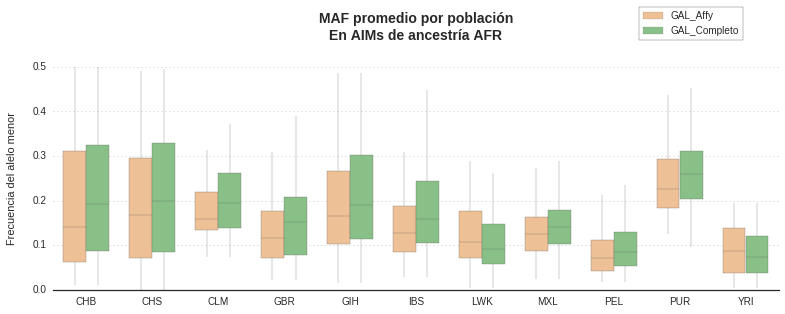

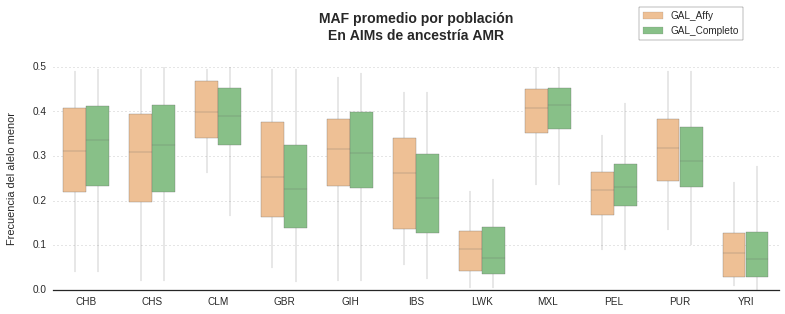

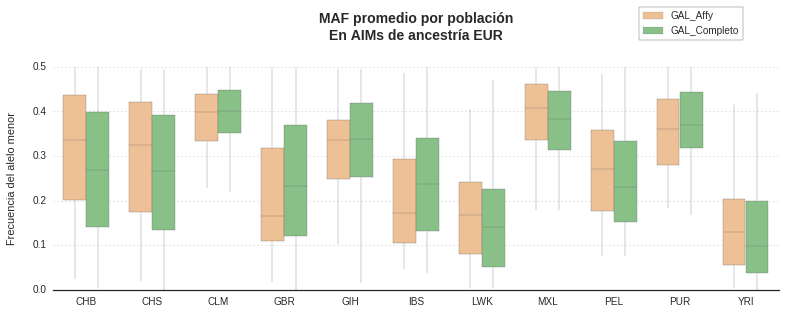

In [217]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sources.thousand_genomes import ThousandGenomes
from components.dataset import Dataset
from helpers.plot_helpers import panel_colors, hide_spines_and_ticks
from plotters.maf_plotter import MAFPlotter

sns.set_context("notebook")
sns.set_style("white")


# for level in ["superpopulation", "population"]:
for level in ["population"]:
    for ancestry in ["AFR", "AMR", "EUR"]:
        frames = []

        for panel in Panel.all_panels():
            if panel.label == "GAL_Faltantes":
                continue
            mafs = ThousandGenomes.mafs()[level][panel.label]
            info = panel.extra_info["population"]
            mafs["ancestry"] = info
            mafs = mafs.reset_index()
            mafs["panel"] = panel.label
            long_maf = pd.melt(mafs, id_vars=["panel", "ancestry", "SNP"])
            long_maf = long_maf.rename(columns={"value": "MAF"})
            frames.append(long_maf)

        long_mafs = pd.concat(frames)
        mask = long_mafs["CLST"].isin(Dataset.used_populations())
        long_mafs = long_mafs[mask]
        long_mafs = long_mafs.replace("NAM", "AMR")
        mask = long_mafs["ancestry"] == ancestry
        long_mafs = long_mafs[mask]

        panel_labels = long_df["panel"].unique()
        colors = [v for k, v in panel_colors().items() if k in panel_labels]

        fig = plt.figure(figsize=(13, 4))
        ax = fig.add_subplot(111)
        ax = sns.boxplot(x="CLST", y="MAF", hue="panel", data=long_mafs, ax=ax,
                         linewidth=0.3, showcaps=False, showfliers=False,
                         palette=sns.color_palette(colors), width=0.70)
        MAFPlotter()._boxplot_aesthetics(ax, True)
        ax.set_title(ax.get_title() + "\nEn AIMs de ancestría " + ancestry,
                     y=1.1, fontweight="bold", fontsize=14)
        
        plt.show()
    

/home/juan/miniconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1572: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/juan/miniconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1574: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


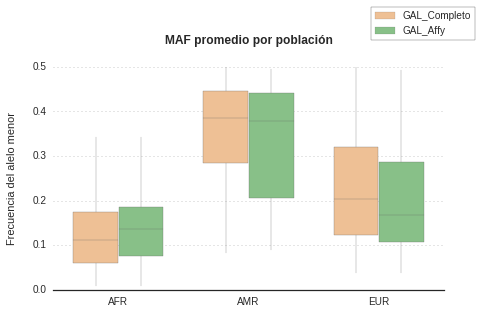

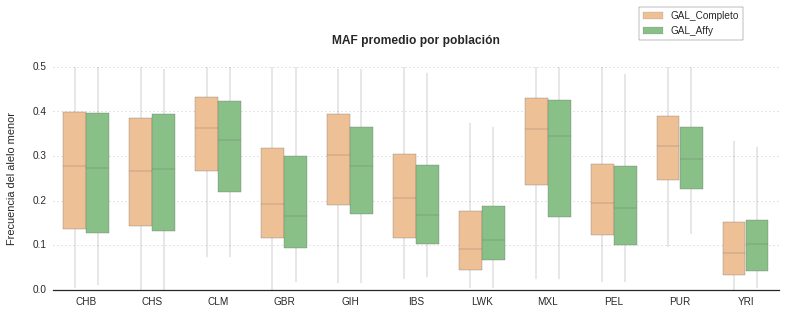

In [216]:
import seaborn as sns

from plotters.maf_plotter import MAFPlotter


sns.set_context("notebook")
sns.set_style("white")


MAFPlotter().MAF_comparison_boxplot()

^ Should mean continental MAFs be similar between 1000 Genomes samples and the ones in Galanter csv? They are not.

# La series de SNPs contra frecuencias en cada continente

/home/juan/miniconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1572: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/juan/miniconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1574: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


KeyboardInterrupt: 

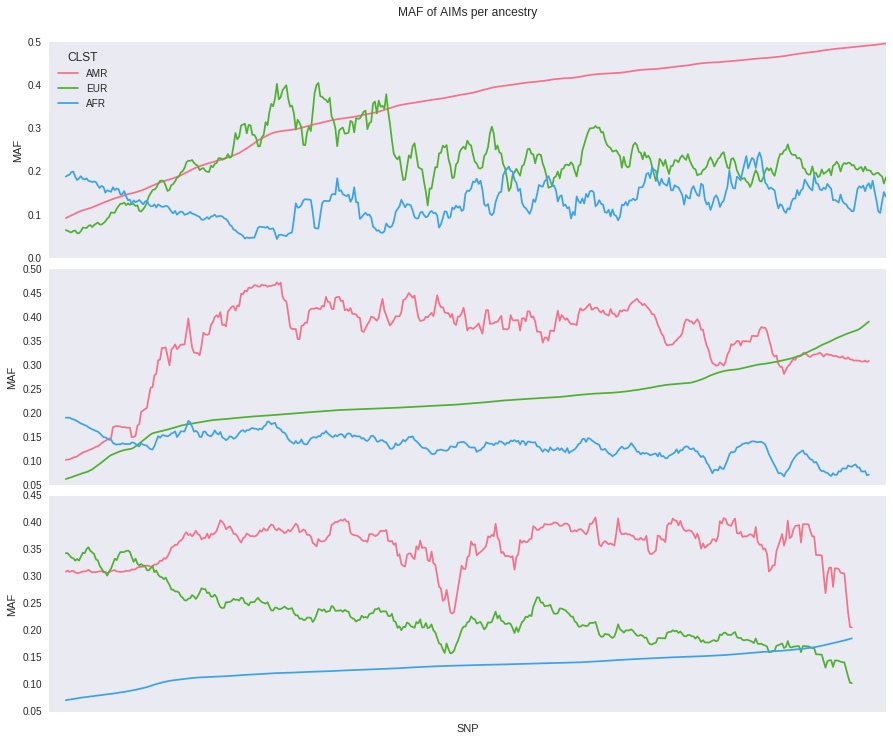

In [179]:
import pandas as pd

from helpers.plot_helpers import hide_spines_and_ticks, population_colors
from sources.thousand_genomes import ThousandGenomes
from os.path import expanduser


sns.set_style("dark")

continents = ["AMR", "EUR", "AFR"]
df = ThousandGenomes.mafs()["superpopulation"]["GAL_Completo"][continents]

fig = plt.figure(figsize=(15, 12))
ax = None

for i, continent in enumerate(continents):
    ax = fig.add_subplot(3, 1, i+1)
    df = df.sort_values(by=continent)
    df = pd.rolling_mean(df, window=10)
    colors = population_colors().values()
    ax = df.plot(ax=ax, rot=90, color=sns.color_palette("husl", 3))
    ax.set_xticklabels([])
    ax.set_ylabel("MAF")
    ax.xaxis.set_label("")
    hide_spines_and_ticks(ax, spines="all")
    if i+1 != 1:
        ax.legend_.set_visible(False)
    else:
        ax.set_title("MAF of AIMs per ancestry", y=1.1)

plt.subplots_adjust(left=None, right=None, hspace=0.05)
plt.savefig(expanduser("~/tesina/charts/panel_analyses/MAF_series"),
            dpi=400, bbox_inches="tight")
plt.show()

Se podría decir que las series EUR y AFR se correlacionan negativamente... No mucho más. AMR no dice nada.

# Info about the datasets

In [94]:
from pandas import DataFrame
from components.dataset import Dataset
from sources.thousand_genomes import ThousandGenomes

tg = ThousandGenomes()
all_pop_codes = set()
summary = {}

for dataset in Dataset.all_datasets():
    summary[dataset.label] = {
        "Muestras": len(dataset.sample_ids),
        "Nombre": dataset.name,
        "Poblaciones": ", ".join(dataset.pop_codes[::-1])
    }

    info = tg.samples_from_pop_codes(dataset.pop_codes).reset_index()
    info = info.groupby(["superpopulation", "population", "gender"]).size()
    info = info.reset_index()
    info = info.pivot_table(index=["superpopulation", "population"],
                            columns="gender", values=0, margins=True)
    
    dataset.info = info
    all_pop_codes |= set(dataset.pop_codes)

print(DataFrame(summary).T.to_latex())
tg.population_names().loc[all_pop_codes]

\begin{tabular}{llll}
\toprule
{} & Muestras &                                        Nombre &                                        Poblaciones \\
\midrule
L     &      347 &                                       Latinos &                                 PUR, CLM, MXL, PEL \\
LE    &      545 &                             Latinos, Europeos &                       GBR, IBS, PUR, CLM, MXL, PEL \\
LEA   &      752 &                  Latinos, Europeos, Africanos &             LWK, YRI, GBR, IBS, PUR, CLM, MXL, PEL \\
LEAC  &      960 &          Latinos, Europeos, Africanos, Chinos &   CHS, CHB, LWK, YRI, GBR, IBS, PUR, CLM, MXL, PEL \\
LEACI &     1063 &  Latinos, Europeos, Africanos, Chinos, Indios &  GIH, CHS, CHB, LWK, YRI, GBR, IBS, PUR, CLM, M... \\
\bottomrule
\end{tabular}



,description,superpopulation
population,,
PEL,"Peruvians from Lima, Peru",AMR
IBS,Iberian Population in Spain,EUR
PUR,Puerto Ricans from Puerto Rico,AMR
YRI,"Yoruba in Ibadan, Nigeria",AFR
MXL,Mexican Ancestry from Los Angeles USA,AMR
CHS,Southern Han Chinese,EAS
GIH,"Gujarati Indian from Houston, Texas",SAS
GBR,British in England and Scotland,EUR
CHB,"Han Chinese in Bejing, China",EAS


In [95]:
df2 = dataset.info["All"].reset_index().drop("superpopulation", axis=1).set_index("population")
df3 = df.join(df2)
df3

CLST,AMR,EUR,AFR,All
SNP,,,,
rs10764919,NaN,NaN,NaN,NaN
rs10437653,NaN,NaN,NaN,NaN
rs12185395,NaN,NaN,NaN,NaN
rs349323,NaN,NaN,NaN,NaN
rs1535661,NaN,NaN,NaN,NaN
rs1952790,NaN,NaN,NaN,NaN
rs11186960,NaN,NaN,NaN,NaN
rs7515867,NaN,NaN,NaN,NaN
rs12329755,NaN,NaN,NaN,NaN


In [96]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from components.panel import Panel
from components.dataset import Dataset


genos = Panel("GAL_Completo").genotypes_1000G()

idx = pd.IndexSlice
# genos.loc[idx[:, Dataset("LEA").pop_codes, :]]
genos
pop_codes = Dataset("L").pop_codes
print(genos.loc[idx[:, pop_codes], :].ix[:5, :5].reset_index()\
      .drop(["superpopulation", "population"], axis=1).to_latex())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
\begin{tabular}{llrrrrr}
\toprule
{} &   sample &  rs6685064 &  rs12085319 &  rs2745285 &  rs4920310 &  rs6684063 \\
\midrule
0 &  HG01112 &          0 &           1 &          1 &          0 &          0 \\
1 &  HG01113 &          0 &           1 &          1 &          1 &          1 \\
2 &  HG01119 &          0 &           1 &          1 &          1 &          1 \\
3 &  HG01121 &          1 &           0 &          2 &          0 &          1 \\
4 &  HG01122 &          2 &           1 &          1 &          0 &          0 \\
\bottomrule
\end{tabular}



In [97]:
snps = ["rs6685064", "rs7598069"]
example_snps = Panel("GAL_Completo").extra_info.loc[snps]
example_snps = example_snps[["chr", "position", "NAM_AF", "EUR_AF", "AFR_AF", "population"]]
example_snps.columns = ["Cromosoma", "Posición", "Freq. AMR", "Freq. EUR", "Freq. AFR", "Componente a inferir"]
print(example_snps.to_latex())

\begin{tabular}{lrrrrrl}
\toprule
{} &  Cromosoma &  Posición &  Freq. AMR &  Freq. EUR &  Freq. AFR & Componente a inferir \\
rs\_id     &            &           &            &            &            &                      \\
\midrule
rs6685064 &          1 &   1201155 &      0.244 &       0.93 &      0.422 &                  EUR \\
rs7598069 &          2 &  98127823 &      0.011 &       0.61 &      0.971 &                  NAM \\
\bottomrule
\end{tabular}



# Allele counts per cluster

/home/juan/tesina/charts/panel_analyses/SNP_freqs_per_ancestry__GAL_Affy


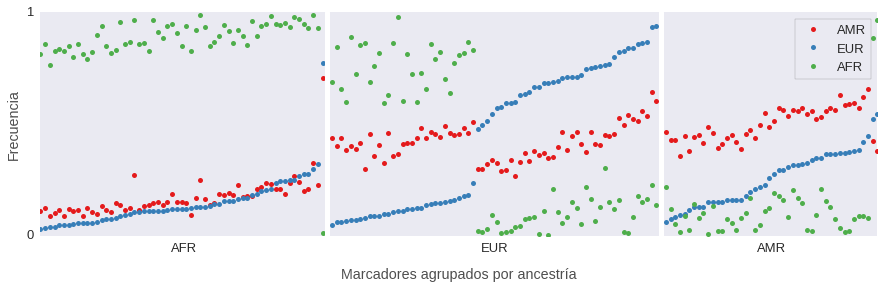

/home/juan/tesina/charts/panel_analyses/SNP_freqs_per_ancestry__GAL_Completo


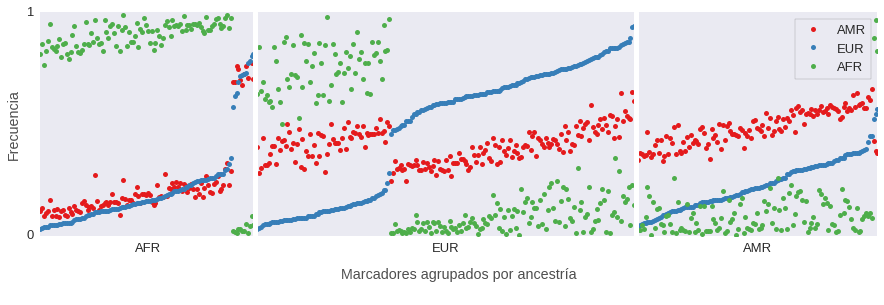

/home/juan/tesina/charts/panel_analyses/SNP_freqs_per_ancestry__GAL_Faltantes


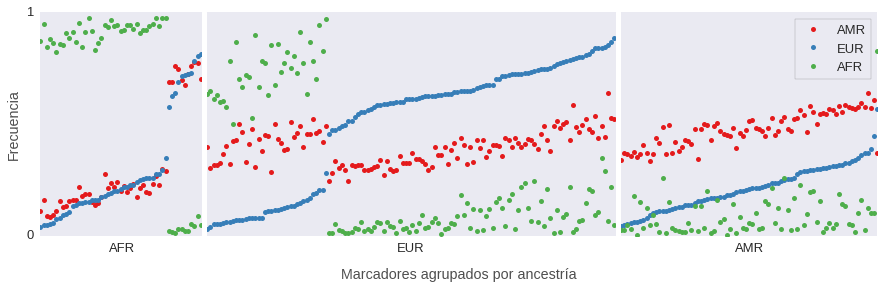

/home/juan/tesina/charts/panel_analyses/SNP_freqs_per_ancestry__CPx1


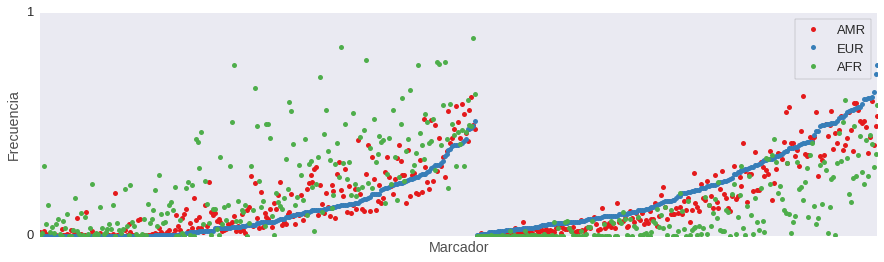

/home/juan/tesina/charts/panel_analyses/SNP_freqs_per_ancestry__CPx10


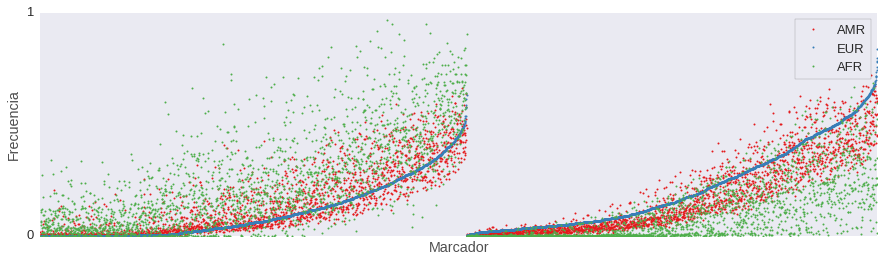

/home/juan/tesina/charts/panel_analyses/SNP_freqs_per_ancestry__CPx100


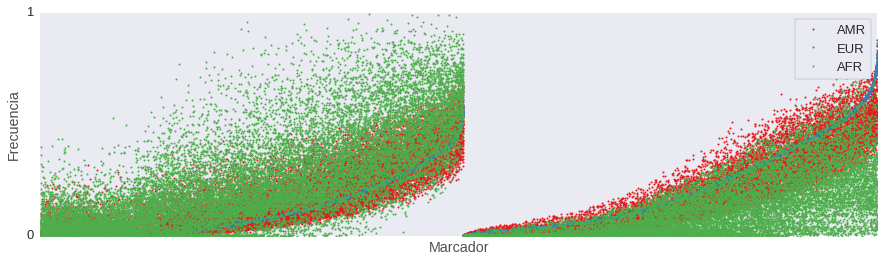

/home/juan/tesina/charts/panel_analyses/SNP_freqs_per_ancestry__CPx1_filtered


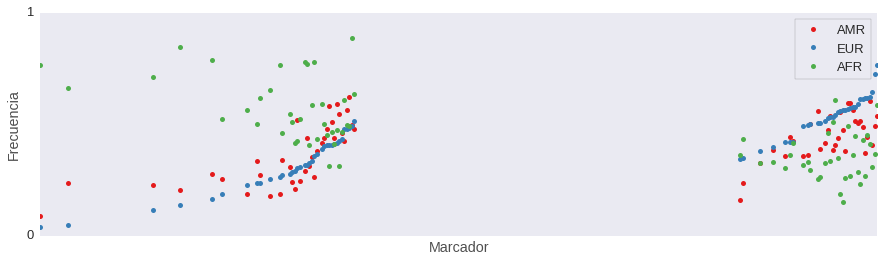

/home/juan/tesina/charts/panel_analyses/SNP_freqs_per_ancestry__CPx10_filtered


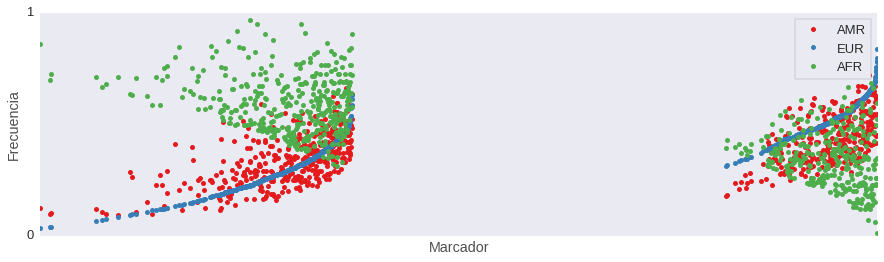

/home/juan/tesina/charts/panel_analyses/SNP_freqs_per_ancestry__CPx100_filtered


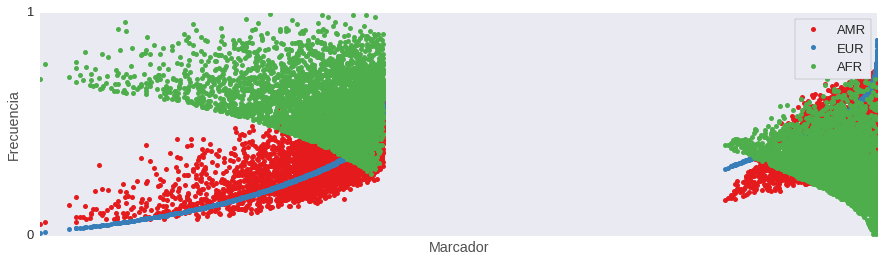

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from subprocess import call

from components.panel import Panel
from components.dataset import Dataset
from os.path import expanduser, join


sns.set_context("notebook", font_scale=1.3)
sns.set_style("dark", {"axes.edgecolor": ".5",
                        "axes.labelcolor": ".3"})

fdir = expanduser("~/tesina/charts/panel_analyses")
panels = Panel.all_panels() + Panel.all_control_panels()
more_panels = Panel.all_control_panels()
count = 0

for panel in panels + more_panels:
    genotypes = panel.genotypes_1000G()
    idx = pd.IndexSlice
    genotypes = genotypes.loc[idx[:, Dataset.used_populations()], :]
    level = "superpopulation"

    grouped = genotypes.groupby(level=level)
    total = grouped.count() * 2
    freqs = grouped.sum() / (grouped.count() * 2)
    freqs = freqs.transpose()[["AMR", "EUR", "AFR"]]
    
    if hasattr(panel, "extra_info"):
        freqs["AIM ancestry"] = panel.extra_info["population"]
        freqs = freqs.sort_values(["AIM ancestry", "EUR"])
        freqs = freqs.replace("NAM", "AMR")
    else:
        freqs["order"] = freqs["EUR"] > freqs[["AFR", "AMR"]].mean(axis=1)
        freqs = freqs.sort_values(["order", "EUR"])
        
    freqs.columns.name = ""
    
    freqs = freqs.reset_index()
    freqs["AMR - EUR"] = abs(freqs.AMR - freqs.EUR)
    freqs["AMR - AFR"] = abs(freqs.AMR - freqs.AFR)
    freqs["AFR - EUR"] = abs(freqs.AFR - freqs.EUR)
    panel.freqs = freqs

    # Plot
    markersize = 5 if len(freqs) < 1000 else 2
    colors = sns.color_palette("Set1", 3)
    
    count += 1
    second_round = count > len(panels)
    if second_round and "AIM ancestry" not in freqs:
        freqs = freqs[abs((freqs.EUR + freqs.AFR)/2) > .35]
        markersize = 5
    
    ax = freqs[["AMR", "EUR", "AFR"]].plot(
        linestyle="", marker="o", markersize=markersize,
        figsize=(15, 4), color=colors
    )
    
    if "AIM ancestry" in freqs:
        xlabel_order = freqs["AIM ancestry"].unique()
        counts = freqs.groupby("AIM ancestry").size()[xlabel_order]
        xticks = counts.cumsum() - counts / 2
        ax.set_xticklabels(xticks.index)
        ax.set_xticks(xticks)
        for xlim in counts.cumsum():
            ax.axvline(xlim, linewidth=5, color="white")
        ax.set_xlabel("Marcadores agrupados por ancestría\n", labelpad=13)
    else:
        ax.set_xlabel("Marcador")
        ax.set_xticks([])
    
    ax.set_yticks([0, 1])
    ax.set_ylabel("Frecuencia")
    sns.despine(left=True)
    ax.legend(frameon=True)
    
    filepath = join(fdir, "SNP_freqs_per_ancestry__{}".format(panel.label))
    if second_round:
        filepath += "_filtered"
    plt.savefig(filepath)
    print(filepath)
    plt.show()


    
    # FILTRAR en los CPx sólo graficar los snps con freq diff > umbral

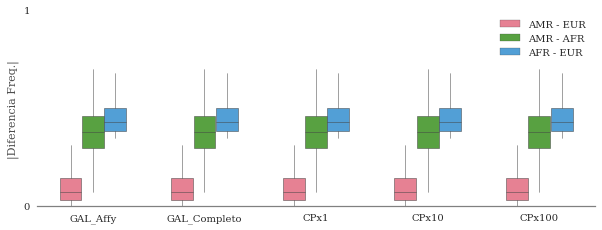

In [34]:
frames = []

for panel in panels:
    freqs = freqs.filter(regex="-")
    freqs["panel"] = panel.label   
    frames.append(freqs)

all_freqs = pd.concat(frames)
all_freqs_long = pd.melt(all_freqs, id_vars="panel")
all_freqs_long = all_freqs_long[all_freqs_long["panel"] != "GAL_Faltantes"]
all_freqs_long.columns = ["Panel", "Poblaciones", "|Diferencia Freq.|"]


sns.set_context("notebook")
sns.set_style("white", {"font.family": "serif",
                        "axes.labelcolor": ".3"})


fig = plt.figure(figsize=(10, 3.5))
ax = fig.add_subplot(111)
ax = sns.boxplot(x="Panel", y="|Diferencia Freq.|", hue="Poblaciones", ax=ax,
                 data=all_freqs_long, palette=sns.color_palette("husl", 3),
                 showfliers=False, showcaps=False, width=.6, linewidth=.5)
ax.legend_.set_title("")
ax.set_yticks([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("")
sns.despine(left=True)
ax.spines["bottom"].set_color(".5")


plt.savefig(join(fdir, "freq_dif_entre_ancestrias"))